In [1]:
!pip install soundfile librosa

In [2]:
import numpy as np
import soundfile as sf
import librosa
import librosa.display
import os, sys, argparse
import scipy
import scipy.io.wavfile
from scipy import signal
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
%matplotlib notebook

import bss_eval

In [3]:
# MODIFY THE SAMPLE AND FILTER
sample_mode = 'speech' # speech or music
filter_mode = 'Lowpass' # lowpass, highpass, or bandpass

In [4]:
# DO NOT MODIFY PARAMETER!
fc = [500, 5000]
fs = 16000
len_filter = 512
if filter_mode.lower() == 'lowpass':
    coeff_b = signal.firwin(len_filter, [1, fc[0]], nyq = fs//2, pass_zero = False)
elif filter_mode.lower() == 'highpass':
    coeff_b = signal.firwin(len_filter, [fc[1], fs//2 - 1], nyq = fs//2, pass_zero = False)
elif filter_mode.lower() == 'bandpass':
    coeff_b = signal.firwin(len_filter, [fc[0], fc[1]], nyq = fs//2, pass_zero = False)
else:
    raise ValueError('Select \'lowpass\', \'highpass\', or \'bandpass\' instead of \'{}\''.format(filter_mode))

In [5]:
sig, _ = librosa.load(os.path.join(sample_mode, 'source.wav'), mono = True, sr = fs) # source audio file
dis, _ = librosa.load(os.path.join(sample_mode, 'record.wav'), mono = True, sr = fs) # record audio file
ref = signal.lfilter(coeff_b, 1, sig)

In [6]:
# DO NOT MODIFY BELOW CODE!
# Modify recorded audio file
# Remove silent
for th in np.array([80, 70, 60, 50, 40, 30]):
    dis_, on_off = librosa.effects.trim(dis, top_db = th)
    if (on_off[1] - on_off[0] > len(sig) * 0.65) and (on_off[1] - on_off[0] <= len(sig)):
        break
# Synchronize two signal
corr = fftconvolve(sig, dis_[::-1], mode = 'same')
delay = 2 * (len(corr)//2 - np.argmax(corr))
delay = np.max([delay, 0])
print('{:.2f} second delay in audio file'.format(delay / fs))
dis_rs = np.zeros(len(ref))
if len(dis_) + delay > len(ref):
    dis_rs[delay:delay + len(dis_[:len(ref) - delay])] = dis_[:len(ref) - delay]
    print('[warning] last {:.2f} second recored signal reducted due to recording environment'.format((len(dis_) - len(dis_[:len(ref) - delay])) / fs))
else:
    dis_rs[delay:delay + len(ref)] = dis_[:len(ref)]

0.00 second delay in audio file


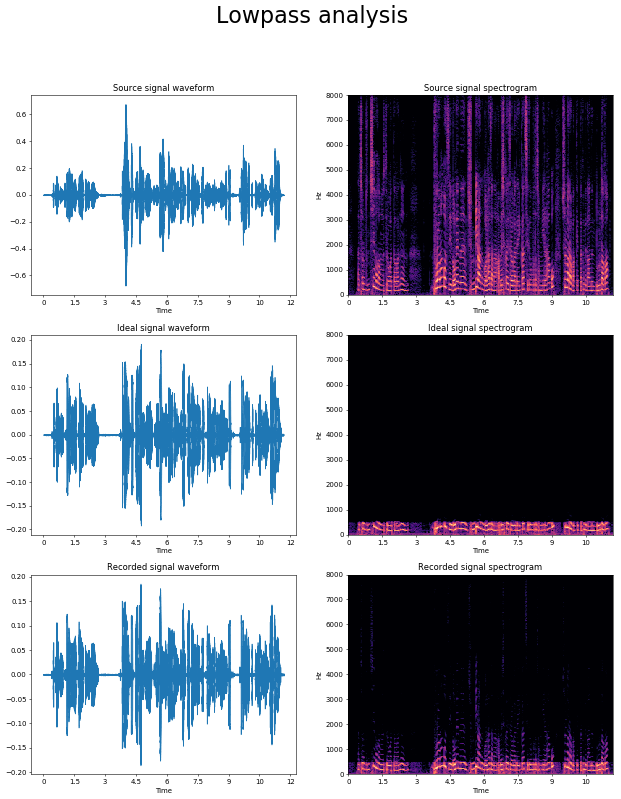

In [7]:
fig = plt.figure(dpi = 50, figsize = (15, 18), facecolor = 'white')
fig.suptitle('{} analysis'.format(filter_mode), fontsize = 32)
ax = plt.subplot(321)
ax.set(title = 'Source signal waveform')
librosa.display.waveshow(sig, sr = fs, max_points = fs//2, x_axis = 'time')
ax = plt.subplot(322)
ax.set(title = 'Source signal spectrogram')
SIG = librosa.amplitude_to_db(np.abs(librosa.stft(sig)), ref = np.max)
librosa.display.specshow(SIG, y_axis = 'linear', x_axis = 'time', sr = fs)
ax = plt.subplot(323)
ax.set(title = 'Ideal signal waveform')
librosa.display.waveshow(ref, sr = fs, max_points = fs//2, x_axis = 'time')
ax = plt.subplot(324)
ax.set(title = 'Ideal signal spectrogram')
REF = librosa.amplitude_to_db(np.abs(librosa.stft(ref)), ref = np.max)
librosa.display.specshow(REF, y_axis = 'linear', x_axis = 'time', sr = fs)
ax = plt.subplot(325)
ax.set(title = 'Recorded signal waveform')
librosa.display.waveshow(dis_rs, sr = fs, max_points = fs//2, x_axis = 'time')
ax = plt.subplot(326)
ax.set(title = 'Recorded signal spectrogram')
DIS = librosa.amplitude_to_db(np.abs(librosa.stft(dis_rs)), ref = np.max)
librosa.display.specshow(DIS, y_axis = 'linear', x_axis = 'time', sr = fs)

In [8]:
# DO NOT MODIFY BELOW CODE
# Objective measure
sdr, _, _, _ = bss_eval.bss_eval_sources(np.reshape(ref, (1, -1)), np.reshape(dis_rs, (1, -1)))
print('Signal-to-distortion ratio(SDR) score is {:.4f}'.format(sdr[0]))

Signal-to-distortion ratio(SDR) score is -11.7912


In [9]:
# Save figure
fig.savefig('{}_exp.png'.format(filter_mode), transparent = True)
ax.clear()
# Save reference signal
scipy.io.wavfile.write(os.path.join(sample_mode, '{}_reference.wav'.format(filter_mode)), fs, (np.iinfo(np.int16).max * ref.T).astype(np.int16))